<a href="https://colab.research.google.com/github/herysedra/ady_cov/blob/master/scr/modely_RP/R_araky_Ferguson_et_al_Fameno.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats
import matplotlib
import pickle

import datetime
import time
from datetime import date

import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter
import seaborn as sns

from numpy import log,exp
from numpy.random import multinomial
from scipy.stats import uniform, gamma, gengamma, poisson, nbinom, expon
from scipy.integrate import quad

tilyvoa = pd.read_csv("/content/drive/My Drive/data/tilyvoa.csv")

mdg_databe = pd.read_csv("/content/drive/My Drive/data/databe mdg.csv")

#tilyvoa.set_index('Daty', inplace=True)

tilyvoafar = tilyvoa.groupby('Faritra')
tilyvoamdg = tilyvoafar.get_group('Madagasikara')
tilyvoamdg.set_index('Daty', inplace=True)

tilyvoamdg.index = pd.to_datetime(tilyvoamdg.index)

tilyvoatana = tilyvoafar.get_group('Antananarivo')
tilyvoatana.set_index('Daty', inplace=True)

tilyvoatana.index = pd.to_datetime(tilyvoatana.index)

tilyvoatoa = tilyvoafar.get_group('Toamasina')
tilyvoatoa.set_index('Daty', inplace=True)

tilyvoatoa.index = pd.to_datetime(tilyvoatoa.index)


path_to_save = '/content/drive/My Drive/sary/'
path_data = '/content/drive/My Drive/data/'

In [0]:
# Voa vaovao (observed incidence)
Ivao = tilyvoamdg['Voatomb']
Ivao

Daty
2020-03-18     0.0
2020-03-19     3.0
2020-03-20     2.0
2020-03-21    10.0
2020-03-22     1.0
              ... 
2020-05-29    42.0
2020-05-30    60.0
2020-05-31    32.0
2020-06-01    36.0
2020-06-02    19.0
Name: Voatomb, Length: 77, dtype: float64

In [0]:
# Fakàna mivantana
E=5200
BURN_IN=200

#Tombana mialoha (prior distributions)

# Hoan'ny taha sorisoritry ny fifindrana (infectioness profile distribution)

daty_data_manom = datetime.date(2020,5,9)
daty_data_mifar = datetime.date(2020,5,26)

format_date = lambda date_py: '{}-{}-{}'.format(date_py.year, date_py.month, date_py.day)
datyf_data_manom = format_date(daty_data_manom)
datyf_data_mifar = format_date(daty_data_mifar)

# Discretization of the serial interval distribution
#si_sh = 1/(0.62**2) # Report 13
#si_sc = 6.5/si_sh

si_sh = (6.48**2)/(3.83**2) # Planning tool: Short-term forecasts
si_sc = 6.48/si_sh


def discr_si(t):
  if t == 0:
    discrsi = 0
  elif t == 1:
    discrsi = gengamma.cdf(3/2, si_sh, 1, loc = 0, scale = si_sc)
  else:
    discrsi = gengamma.cdf(t+1/2, si_sh, 1, loc = 0, scale = si_sc) - gengamma.cdf(t-1/2, si_sh, 1, loc = 0, scale = si_sc)
  return discrsi

#discr_si1 = gengamma.cdf(3/2, si_sh, 1, loc = 0, scale = si_sc)

# Specification of time-windows
# 1 The total incidence over a generic window (t-k+1,t)
# 2 The total infectiousness over a generic window (t-k+1,t)

# 3 The scale of the posterior Gamma of R(t,k)

# 4 The shape parameters of the posterior predictive negative binomial of I(t+1)
# 5 Use the pmf of the posterior predictive negative binomial to compute
# each additive contribution at time s then for-loop for s in the time interval

# Posterior distribution for Rt


In [0]:
1/(0.62**2)
mlk = gengamma.cdf(2+1/2, si_sh, 1, loc = 0, scale = si_sc)
lkm = gengamma.cdf(2-1/2, si_sh, 1, loc = 0, scale = si_sc)
print('mlk =', mlk)
print('lkm =', lkm)
print('mlk - lkm =', mlk - lkm)

print('discr_si(2) =', discr_si(2))
print('discr_si(0) =', discr_si(0))
print('discr_si(1) =', discr_si(1))



mlk = 0.13359942723435544
lkm = 0.04653485923726771
mlk - lkm = 0.08706456799708773
discr_si(2) = 0.08706456799708773
discr_si(0) = 0
discr_si(1) = 0.04653485923726771


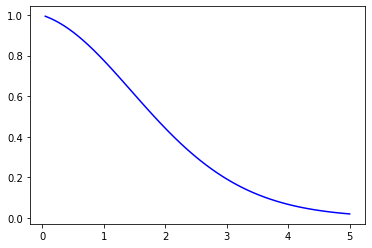

In [0]:
# Variation of discr_si1 with rapport to the shape parameter a

# 100 linearly spaced numbers
x = np.linspace(0,5,100)

# the function
def discr_si1f(a):
  return gengamma.cdf(3/2, a, 1, loc = 0, scale = 1)

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)


# plot the functions
plt.plot(x, discr_si1f(x), 'b')




# show the plot
plt.show()

In [0]:
discr_si_lst = []
for i in range(20):
  discr_si_lst.append(discr_si(i))

discr_si_lst

[0,
 0.04653485923726771,
 0.08706456799708773,
 0.1120607764381733,
 0.11934593229534449,
 0.11454033566501248,
 0.10292237624521244,
 0.08837543531019798,
 0.07340392972354359,
 0.059441261522055866,
 0.0471811528841255,
 0.036848747972925255,
 0.028397304891685793,
 0.021640276815890203,
 0.016334404377011058,
 0.012228465410722977,
 0.009089308888731606,
 0.0067136371140041895,
 0.004931350622852548,
 0.0036042672430812717]

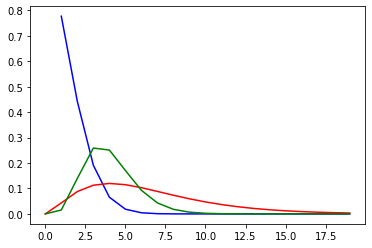

In [0]:
# 100 linearly spaced numbers
x = [ i for i in range(20)]


# setting the axes at the centre
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)


# plot the functions
plt.plot(x,discr_si1f(x), 'b')
plt.plot(x, gengamma.pdf(x, si_sh, 1, loc = 0, scale = si_sc), 'r')
plt.plot(x, gengamma.pdf(x, 6.5, 1, loc = 0, scale = 0.62), 'g')

# show the plot
plt.show()

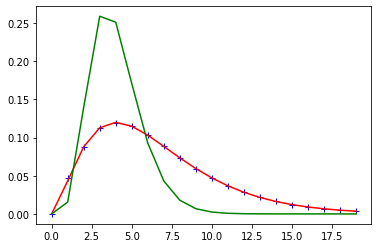

In [0]:
# 100 linearly spaced numbers
x = [ i for i in range(20)]


# setting the axes at the centre
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)


# plot the functions
plt.plot(x, discr_si_lst, 'b',  marker ="+",ls = 'None')
plt.plot(x, gengamma.pdf(x, si_sh, 1, loc = 0, scale = si_sc), 'r')
plt.plot(x, gengamma.pdf(x, 6.5, 1, loc = 0, scale = 0.62), 'g')

# show the plot
plt.show()

In [0]:
# construction of I(t) with t an integer
# construction of I(daty) for daty in range((daty_data_mifar - daty_data_manom).days +1)

dIvao = pd.DataFrame(data =Ivao)

dIvao['Datint'] = range(len(Ivao))

dIvao['Voatomb'].loc[dIvao.index == datyf_data_manom]
dIvao['Voatomb'].loc[datyf_data_manom]
dIvao

,Voatomb,Datint
Daty,,
2020-03-18,0.0,0
2020-03-19,3.0,1
2020-03-20,2.0,2
2020-03-21,10.0,3
2020-03-22,1.0,4
...,...,...
2020-05-29,42.0,72
2020-05-30,60.0,73
2020-05-31,32.0,74


In [0]:
def f1(t):
  rt = dIvao['Voatomb'].loc[t]
  return rt

datyt = datetime.date(2020,5,23)
datytf = format_date(datyt)

print('f1(datytf)', f1(datytf))

def f2(daty):
  andr0 = dIvao['Voatomb'].loc[dIvao.index == daty]
  return andr0

datyt = datetime.date(2020,5,20)
datytf = format_date(datyt)

de = datyt.strftime("%Y-%m-%d")
print('f2(datytf)', f2(datytf))

def andr(t):
  tf = format_date(t)
  andr = dIvao['Voatomb'].loc[tf]
#  tf1 = format_date(t - datetime.timedelta(days = 1))
#  for i in range(k):
#   Irehv = Irehv + dIvao['Voatomb'].loc[tf1]
  return andr

datyt = datetime.date(2020,5,30)

#andr('2020-5-30')


f1(datytf) 40.0
f2(datytf) Daty
2020-05-20    45.0
Name: Voatomb, dtype: float64


In [0]:
# 1 The total incidence over a generic window (t-k+1,t)
# Ireh(t,k) = sum(i = 0 to k-1) Ivao(t - i))

datyt = datetime.date(2020,5,20)

def Ireh(t,k):
  Irehv = 0
  for i in range(k):
    Irehv = Irehv + dIvao['Voatomb'].loc[format_date(t - datetime.timedelta(days = i))]
  return Irehv

  
datyt = datetime.date(2020,5,20)
print('Ivao(datyt) =', dIvao['Voatomb'].loc[format_date(datyt)])
print('Ivao(datyt - 1 andro) =', dIvao['Voatomb'].loc[format_date(datyt - datetime.timedelta(days = 1))])
print('Ireh(datyt,2) =', Ireh(datyt,2))

Ivao(datyt) = 45.0
Ivao(datyt - 1 andro) = 4.0
Ireh(datyt,2) = 49.0


In [0]:
# 2 Tool to compute the total infectiousness over a generic window (t-k+1,t)
# Isi(t,k) = sum(i=0 to k-1) Ivao(t - i)*discr_si(i)

# The definition of Isi(t,k) does not include the term Ivao(t) for i = 0 (because discr_si(0) =0) 
# but include the last term Ivao(t - k + 1)*discr_si(k - 1) for i = k-1. 

def Isi(t,k):
  Ivaosi = 0
  for i in range(k):
    Ivaosi = Ivaosi + dIvao['Voatomb'].loc[format_date(t - datetime.timedelta(days = i))]*discr_si(i)
  return Ivaosi


In [0]:
print('Ivao(datyt) =', dIvao['Voatomb'].loc[datytf])
print('discr_si(1) =', discr_si(1))
print('Ivao(datyt - 1 andro) =', dIvao['Voatomb'].loc[format_date(datyt - datetime.timedelta(days = 1))])
print('Ivao(datyt - 1 andro)*discr_si(1) =', dIvao['Voatomb'].loc[format_date(datyt - datetime.timedelta(days = 1))]*discr_si(1))
print('discr_si(2) =', discr_si(2))
print('Ivao(datyt - 2 andro) =', dIvao['Voatomb'].loc[format_date(datyt - datetime.timedelta(days = 2))])
print('Ivao(datyt - 2 andro)*discr_si(2) =', dIvao['Voatomb'].loc[format_date(datyt - datetime.timedelta(days = 2))]*discr_si(2))
print('sum =',dIvao['Voatomb'].loc[format_date(datyt - datetime.timedelta(days = 1))]*discr_si(1) + dIvao['Voatomb'].loc[format_date(datyt - datetime.timedelta(days = 2))]*discr_si(2))
print('Isi(datyt,3) =', Isi(datyt,3))

Ivao(datyt) = 45.0
discr_si(1) = 0.04653485923726771
Ivao(datyt - 1 andro) = 4.0
Ivao(datyt - 1 andro)*discr_si(1) = 0.18613943694907084
discr_si(2) = 0.08706456799708773
Ivao(datyt - 2 andro) = 18.0
Ivao(datyt - 2 andro)*discr_si(2) = 1.567162223947579
sum = 1.7533016608966498
Isi(datyt,3) = 1.7533016608966498


In [0]:
# The total infectiousness before t

# lsi(t) := um(i=0 to t-1) Ivao(t - i)*discr_si(i)

def lsi(t):
  return Isi(t, (t - daty_data_manom).days +1)

  # for checking, take for example t = daty_data_manom + datetime.timedelta(days = 3)

In [0]:
# 3 The sum of total infectiousness before t over a generic window (t-k+1,t)

def tlsi(t,k):
  tlsi = 0
  for i in range(k):
    tlsi = tlsi + lsi(t - datetime.timedelta(days = k))
  return tlsi

In [0]:
# 4 The shape parameters of the posterior predictive negative binomial of I(t+1)

# pnb(t,k) = Isi(t+1, t - daty_data_manom + 2)*(1/si_sc + Isi(t,k))/(1 + si(t+1, t - daty_data_manom + 2)*(1/si_sc + Isi(t,k)))

def pnb(t,k):
  return lsi(t+datetime.timedelta(days = 1))*(1/si_sc + tlsi(t,k))/(1 + lsi(t+datetime.timedelta(days = 1))*(1/si_sc + tlsi(t,k)))

# pnb(t,k) dia mikajy ny taha herjika hoan'ny NB hoan'ny I(t+1).

In [0]:
# 5 Use the pmf of the posterior predictive negative binomial to compute
# each additive contribution at time s then for-loop for s in the time interval

def lpr(t,k):
  return -np.log(nbinom.pmf(dIvao['Voatomb'].loc[format_date(t + datetime.timedelta(days = 1))], si_sh + Ireh(t,k), pnb(t,k)))


In [0]:
tyty = round(((daty_data_mifar - daty_data_manom).days + 1)/2)
aat = 2*datetime.timedelta(days = 3*4)
print(tyty)
print(aat)

9
24 days, 0:00:00


In [0]:
# APE9_part2 

# for i in range(9):
# t = t_mif - 1 - 9 + 1 - i
# k = t_mif - t - 2*i
APEt92 = []
Prt92 = []

APE92 = 0
for i in range(round(((daty_data_mifar - daty_data_manom).days + 1)/2)-1):
  t = daty_data_mifar - datetime.timedelta(days = 1) - datetime.timedelta(days = ((daty_data_mifar - daty_data_manom).days + 1)/2) + datetime.timedelta(days = 1) - datetime.timedelta(days = i)
  k = (daty_data_mifar - t - datetime.timedelta(days = 2*i)).days
  APE92 = APE92 + lpr(t,k) 
  APEt92.append((lpr(t,k) ,t,k))
  Prt92.append(expon.pdf(lpr(t,k)))

print('For k = 9, APE92 =', APE92)
print('APEt92=', APEt92)
print('Prt92=', Prt92)

For k = 9, APE92 = 52.74080741188091
APEt92= [(4.373195549086329, datetime.date(2020, 5, 17), 9), (3.924942668146567, datetime.date(2020, 5, 16), 8), (6.891798574695045, datetime.date(2020, 5, 15), 7), (10.487220075588368, datetime.date(2020, 5, 14), 6), (4.578988352911644, datetime.date(2020, 5, 13), 5), (3.61176117329061, datetime.date(2020, 5, 12), 4), (13.203969862865474, datetime.date(2020, 5, 11), 3), (5.668931155296871, datetime.date(2020, 5, 10), 2)]
Prt92= [0.012610877433303849, 0.01974326875723659, 0.0010160846923426164, 2.7890621416664002e-05, 0.010265275881737083, 0.027004245805350154, 1.8432691278937493e-06, 0.0034515524788131034]


In [0]:
# APE9_part1 

# for i in range(8):
# t = t_mif - i - 1
# k = 9

APEt91 = []
Prt91 = []

APE91 = 0

for i in range(round(((daty_data_mifar - daty_data_manom).days + 1)/2) - 1):
  t = daty_data_mifar - datetime.timedelta(days = i+1) 
  k = round(((daty_data_mifar - daty_data_manom).days + 1)/2)
  APE91 = APE91 + lpr(t,k)
  APEt91.append((lpr(t,k),t))
  Prt91.append(expon.pdf(lpr(t,k)))

print('For k = 9, APE91 =', APE91)
print('APEt91 =', APEt91)
print('Prt91 =', Prt91)

For k = 9, APE91 = 906.9082999033016
APEt91 = [(212.3622681326409, datetime.date(2020, 5, 25)), (53.31522757552295, datetime.date(2020, 5, 24)), (158.60743906145217, datetime.date(2020, 5, 23)), (146.5798641000907, datetime.date(2020, 5, 22)), (142.29134253955488, datetime.date(2020, 5, 21)), (84.09332498391527, datetime.date(2020, 5, 20)), (95.01502164578028, datetime.date(2020, 5, 19)), (14.643811864344372, datetime.date(2020, 5, 18))]
Prt91 = [5.9188697840050625e-93, 7.006334415282353e-24, 1.3111863723620912e-69, 2.193682967255155e-64, 1.5982882712117506e-62, 3.0111541893232748e-37, 5.438766343016269e-42, 4.36790629941746e-07]


In [0]:
print('For k = 9, APE9 =', APE91+ APE92)
print('For k = 9, Pr9 =', sum(Prt91) + sum(Prt92))
print('For k = 9, Pr9 =/= expon.pdf(APE91 + APE92) =', expon.pdf(APE91+ APE92))

For k = 9, APE9 = 959.6491073151825
For k = 9, Pr9 = 0.07412147572995788
For k = 9, Pr9 =/= expon.pdf(APE91 + APE92) = 0.0


In [0]:
# APEk part 1 for k =/= 9

# for i in range(t_mif - t_man -j)

#APEtk1 = []
#Prk1 = []

APEk1 = []
for j in range(2,9):
  APEj1 = 0
  for i in range(round(((daty_data_mifar - daty_data_manom).days) - j)):
    t = daty_data_mifar - datetime.timedelta(days = i+1) 
    k = j
    APEj1 = APEj1 + lpr(t,k)
  APEk1.append(APEj1)
#  APEtk1.append((APEj1,t))
#  Prk1.append(expon.pdf(APEj1))

print('APEk1 =', APEk1)
# print('APEtk1 =', APEtk1)
# print('Prk1 =', Prk1) 

APEk1 = [1563.3940971017407, 1501.693447494386, 1421.0444263712452, 1345.037748646395, 1200.5663227648163, 1101.278904538523, 998.2789450559962]


In [0]:
# APE2 part 1

APEt21 = []
Prt21 = []

APE21 = 0
for i in range(round(((daty_data_mifar - daty_data_manom).days) - 2)):
    t = daty_data_mifar - datetime.timedelta(days = i+1) 
    k = 2
    APE21 = APE21 + lpr(t,k)
    APEt21.append((lpr(t,k),t))
    Prt21.append(expon.pdf(lpr(t,k)))

print('APE21 =', APE21)
print('APEt21 =', APEt21)
print('Prt21 =', Prt21) 
# print('Pr21 =', sum(Prt21))

APE21 = 1563.3940971017407
APEt21 = [(249.43894449152197, datetime.date(2020, 5, 25)), (65.63288597135403, datetime.date(2020, 5, 24)), (190.14676069853383, datetime.date(2020, 5, 23)), (189.57789966858815, datetime.date(2020, 5, 22)), (197.59154401385297, datetime.date(2020, 5, 21)), (154.06399883292175, datetime.date(2020, 5, 20)), (220.1441878303376, datetime.date(2020, 5, 19)), (10.247370654978, datetime.date(2020, 5, 18)), (51.3134355099703, datetime.date(2020, 5, 17)), (55.20993362054983, datetime.date(2020, 5, 16)), (133.1461568763462, datetime.date(2020, 5, 15)), (9.022187131190435, datetime.date(2020, 5, 14)), (19.487914593567083, datetime.date(2020, 5, 13)), (11.341566147748313, datetime.date(2020, 5, 12)), (7.029311060280009, datetime.date(2020, 5, 11))]
Prt21 = [4.677812774595068e-109, 3.1332842182966805e-29, 2.6321526775595174e-83, 4.6490507078921055e-83, 1.5384477962806174e-86, 1.2326944677829774e-67, 2.4694145471283396e-96, 3.545059024770225e-05, 5.186305681060396e-23, 1

In [0]:
# APE7 part 1

APEt71 = []
Prt71 = []

APE71 = 0
for i in range(round(((daty_data_mifar - daty_data_manom).days) - 7)):
    t = daty_data_mifar - datetime.timedelta(days = i+1) 
    k = 7
    APE71 = APE71 + lpr(t,k)
    APEt71.append((APE71,t))
    Prt71.append(expon.pdf(APE71))

print('APE71 =', APE71)
print('APEt71 =', APEt71)
print('Prt71 =', Prt71) 
# print('Pr71 =', sum(Prt71))

APE71 = 1101.278904538523
APEt71 = [(230.16627814022502, datetime.date(2020, 5, 25)), (290.6561186857625, datetime.date(2020, 5, 24)), (467.7658848769395, datetime.date(2020, 5, 23)), (636.8792812172462, datetime.date(2020, 5, 22)), (809.1276124044479, datetime.date(2020, 5, 21)), (924.7730099505872, datetime.date(2020, 5, 20)), (1073.408417170186, datetime.date(2020, 5, 19)), (1077.0733783738658, datetime.date(2020, 5, 18)), (1097.9670157463117, datetime.date(2020, 5, 17)), (1101.278904538523, datetime.date(2020, 5, 16))]
Prt71 = [1.0966182861677241e-100, 5.883713584101622e-127, 7.10979985653523e-204, 2.5517758845805057e-277, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


In [0]:
# APEk part 2

Prk2 = []

APEk2 = []

for j in range(2,9):
  APEj2 = 0
  for i in range(j-1):
    t = daty_data_manom + datetime.timedelta(days = j - i - 1)
    k = j - i
    APEj2 = APEj2 + lpr(t,k)
  APEk2.append(APEj2)
#  Prk2.append(expon.pdf(APEj2))
 

print('APEk2 =', APEk2)
#print('Prk2 =', Prk2) 

APEk2 = [5.668931155296871, 18.872901018162345, 22.484662191452955, 27.0636505443646, 37.55087061995297, 44.44266919464802, 48.367611862794575]


In [0]:
# APE2 part 2

APEt22 = []
Prt22 = []

APE22 = 0
for i in range(2-1):
    t = daty_data_manom + datetime.timedelta(days = 2-i-1)
    k = 2 - i
    APE22 = APE22 + lpr(t,k)
    APEt22.append((APE22,t))
    Prt22.append(expon.pdf(APE22))

print('APE22 =', APE22)
print('APEt22 =', APEt22)
print('Prt22 =', Prt22) 

APE22 = 5.668931155296871
APEt22 = [(5.668931155296871, datetime.date(2020, 5, 10))]
Prt22 = [0.0034515524788131034]


In [0]:
# lpr(daty_data_manom,1)?
print(lpr(daty_data_manom,1))
print(Ireh(daty_data_manom,1))
print(dIvao['Voatomb'].loc[format_date(daty_data_manom)])
print(pnb(daty_data_manom,1))
print(Isi(daty_data_manom,1))

19.87309263209375
11.0
11.0
0.1700336374000661
0.0


In [0]:
# AP2 in a single part. The treatment in a single part is only possible for k = 2.

APEt2 = []
Prt2 = []

APE2 = 0
for i in range(round(((daty_data_mifar - daty_data_manom).days) - 1)):
    t = daty_data_mifar - datetime.timedelta(days = i+1) 
    k = 2
    APE2 = APE2 + lpr(t,k)
    APEt2.append((lpr(t,k),t))
    Prt2.append(expon.pdf(lpr(t,k)))

print('APE2 =', APE2)
print('APEt2 =', APEt2)
print('Prt2 =', Prt2) 
# print('Pr2 =', sum(Prt2))

APE2 = 1569.0630282570376
APEt2 = [(249.43894449152197, datetime.date(2020, 5, 25)), (65.63288597135403, datetime.date(2020, 5, 24)), (190.14676069853383, datetime.date(2020, 5, 23)), (189.57789966858815, datetime.date(2020, 5, 22)), (197.59154401385297, datetime.date(2020, 5, 21)), (154.06399883292175, datetime.date(2020, 5, 20)), (220.1441878303376, datetime.date(2020, 5, 19)), (10.247370654978, datetime.date(2020, 5, 18)), (51.3134355099703, datetime.date(2020, 5, 17)), (55.20993362054983, datetime.date(2020, 5, 16)), (133.1461568763462, datetime.date(2020, 5, 15)), (9.022187131190435, datetime.date(2020, 5, 14)), (19.487914593567083, datetime.date(2020, 5, 13)), (11.341566147748313, datetime.date(2020, 5, 12)), (7.029311060280009, datetime.date(2020, 5, 11)), (5.668931155296871, datetime.date(2020, 5, 10))]
Prt2 = [4.677812774595068e-109, 3.1332842182966805e-29, 2.6321526775595174e-83, 4.6490507078921055e-83, 1.5384477962806174e-86, 1.2326944677829774e-67, 2.4694145471283396e-96, 3

In [0]:
# APEk for k = 2,...,8

APEk = [x + y for x, y in zip(APEk1, APEk2)]

# APE9
APE9 = APE91 + APE92

print('APE9 =', APE9)
print('APEk =', APEk)

# Probability

# Prk = [x + y for x, y in zip(Prk1, Prk2)]

#Pr9 = sum(Prt91) + sum(Prt92)


#print('Pr9 =', Pr9)
#print('Prk =', Prk)


APE9 = 959.6491073151825
APEk = [1569.0630282570376, 1520.5663485125483, 1443.5290885626982, 1372.1013991907596, 1238.1171933847693, 1145.721573733171, 1046.6465569187908]


In [0]:
# Prior Gamma distribution of Rt

Rtpr_sh = 0.1 # shape
Rtpr_sc =  0.1 # scale

# Posterior distribution for Rt

# Shape parameter :
def Rtps_sh(t):
   return Rtpr_sh + Ireh(t,9)

# Scale
def Rtps_sc(t):
  return 1/(1/Rtpr_sc + tlsi(t,9))

# mean
def Rtps_salan(t):
  return Rtps_sh(t)*Rtps_sc(t)

# 95th and 5th percentiles

def perc95(t):
  return gengamma.ppf(0.95, Rtps_sh(t), 1, loc = 0, scale = Rtps_sc(t))

def perc05(t):
  return gengamma.ppf(0.05, Rtps_sh(t), 1, loc = 0, scale = Rtps_sc(t))


print("Salan'isa R hoan'ny", datyt, ':', Rtps_salan(datyt))

Salan'isa R hoan'ny 2020-05-20 : 9.513276075841821


In [0]:
# Plotting

formatf_date = lambda date_py: '{}/{}'.format(date_py.day, date_py.month)

daty_lst = []

salan_Rt = []
perc95_lst = []
perc05_lst = []

salan_Rt_dat = []
salan_Rt_perc_dat = []

for i in range(round(((daty_data_mifar - daty_data_manom).days) - 1)):
  t = daty_data_manom + datetime.timedelta(days = i+1)
  daty = formatf_date(t)
  daty_lst.append(daty)
  salan_Rt.append(Rtps_salan(t))
  perc95_lst.append(perc95(t))
  perc05_lst.append(perc05(t))
  salan_Rt_dat.append((Rtps_salan(t),t))
  salan_Rt_perc_dat.append((perc95(t),Rtps_salan(t),perc05(t),t))

salan_Rt_perc_dat

[(4.992166663846674, 3.91, 2.9413773420805533, datetime.date(2020, 5, 10)),
 (6.339861271705853, 5.11, 3.9937203467836215, datetime.date(2020, 5, 11)),
 (5.443651734325651,
  4.3100000000000005,
  3.2899071584026176,
  datetime.date(2020, 5, 12)),
 (7.670932918031564,
  6.3100000000000005,
  5.062671914411912,
  datetime.date(2020, 5, 13)),
 (9.427511055602324, 7.91, 6.506113715685868, datetime.date(2020, 5, 14)),
 (9.536743454277362, 8.01, 6.596882297354921, datetime.date(2020, 5, 15)),
 (14.404811200107957, 12.51, 10.728842392464246, datetime.date(2020, 5, 16)),
 (16.653372527922013, 14.61, 12.680288171384852, datetime.date(2020, 5, 17)),
 (17.40048261551094, 15.31, 13.33318001830643, datetime.date(2020, 5, 18)),
 (12.058466834055103,
  10.618232327556617,
  9.255812249185974,
  datetime.date(2020, 5, 19)),
 (10.691894674090715,
  9.513276075841821,
  8.393078351728242,
  datetime.date(2020, 5, 20)),
 (8.211424311902718,
  7.362649508668455,
  6.553149307090941,
  datetime.date(2020,

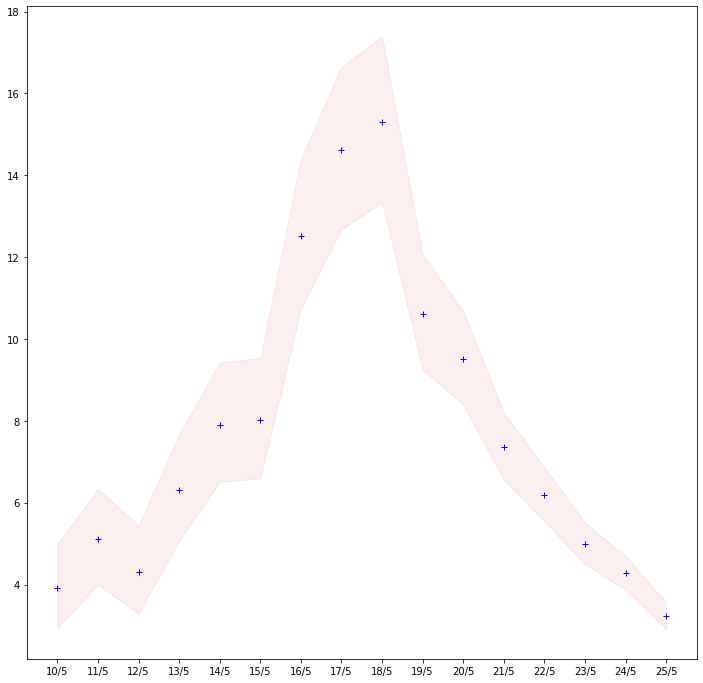

In [0]:
# Plotting

fig = plt.figure(figsize=(12, 12))

plt.plot(daty_lst, salan_Rt, 'b',  marker ="+",ls = 'None')
plt.fill_between(daty_lst, perc05_lst, perc95_lst, alpha=0.08, color="tab:red")


plt.show()